CHIME 180814 Processing using Images
===

This employs the method shown in `CorrFromImage.ipynb`

## Step 1: Find Autocorrelation and 2d Gaussian Fit

  0%|          | 0/5 [00:00<?, ?it/s]B:\dev\sadtrombone\universal\corrfns.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[0:nx,:] = result_shifted[nx-1:2*nx-1,:]
B:\dev\sadtrombone\universal\corrfns.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  temp_array_a[nx:2*nx-1,:] = result_shifted[0:nx-1,:]
100%|██████████| 5/5 [00:01<00:00,  2.85it/s]


,amplitude,xo,yo,sigmaxp,sigmayp,theta,drift (mhz/ms),angle
burst180814,170.460929,348.482341,650.515381,13.423814,86.414958,-9.544872,-13.994177,11.115669
burst180911,161.775841,348.475970,650.475781,11.509405,51.025758,-9.455869,-54.298078,11.026666
burst180917,114.783963,348.498284,650.523744,25.229454,166.514516,-9.645794,-3.758155,11.216591
burst180919,124.668419,348.473626,650.485046,19.671831,38.082662,-9.370266,30.948518,10.941062
burst181028,422.907745,348.498487,650.512116,26.454510,-74.532726,-9.835755,-5.852370,11.406551


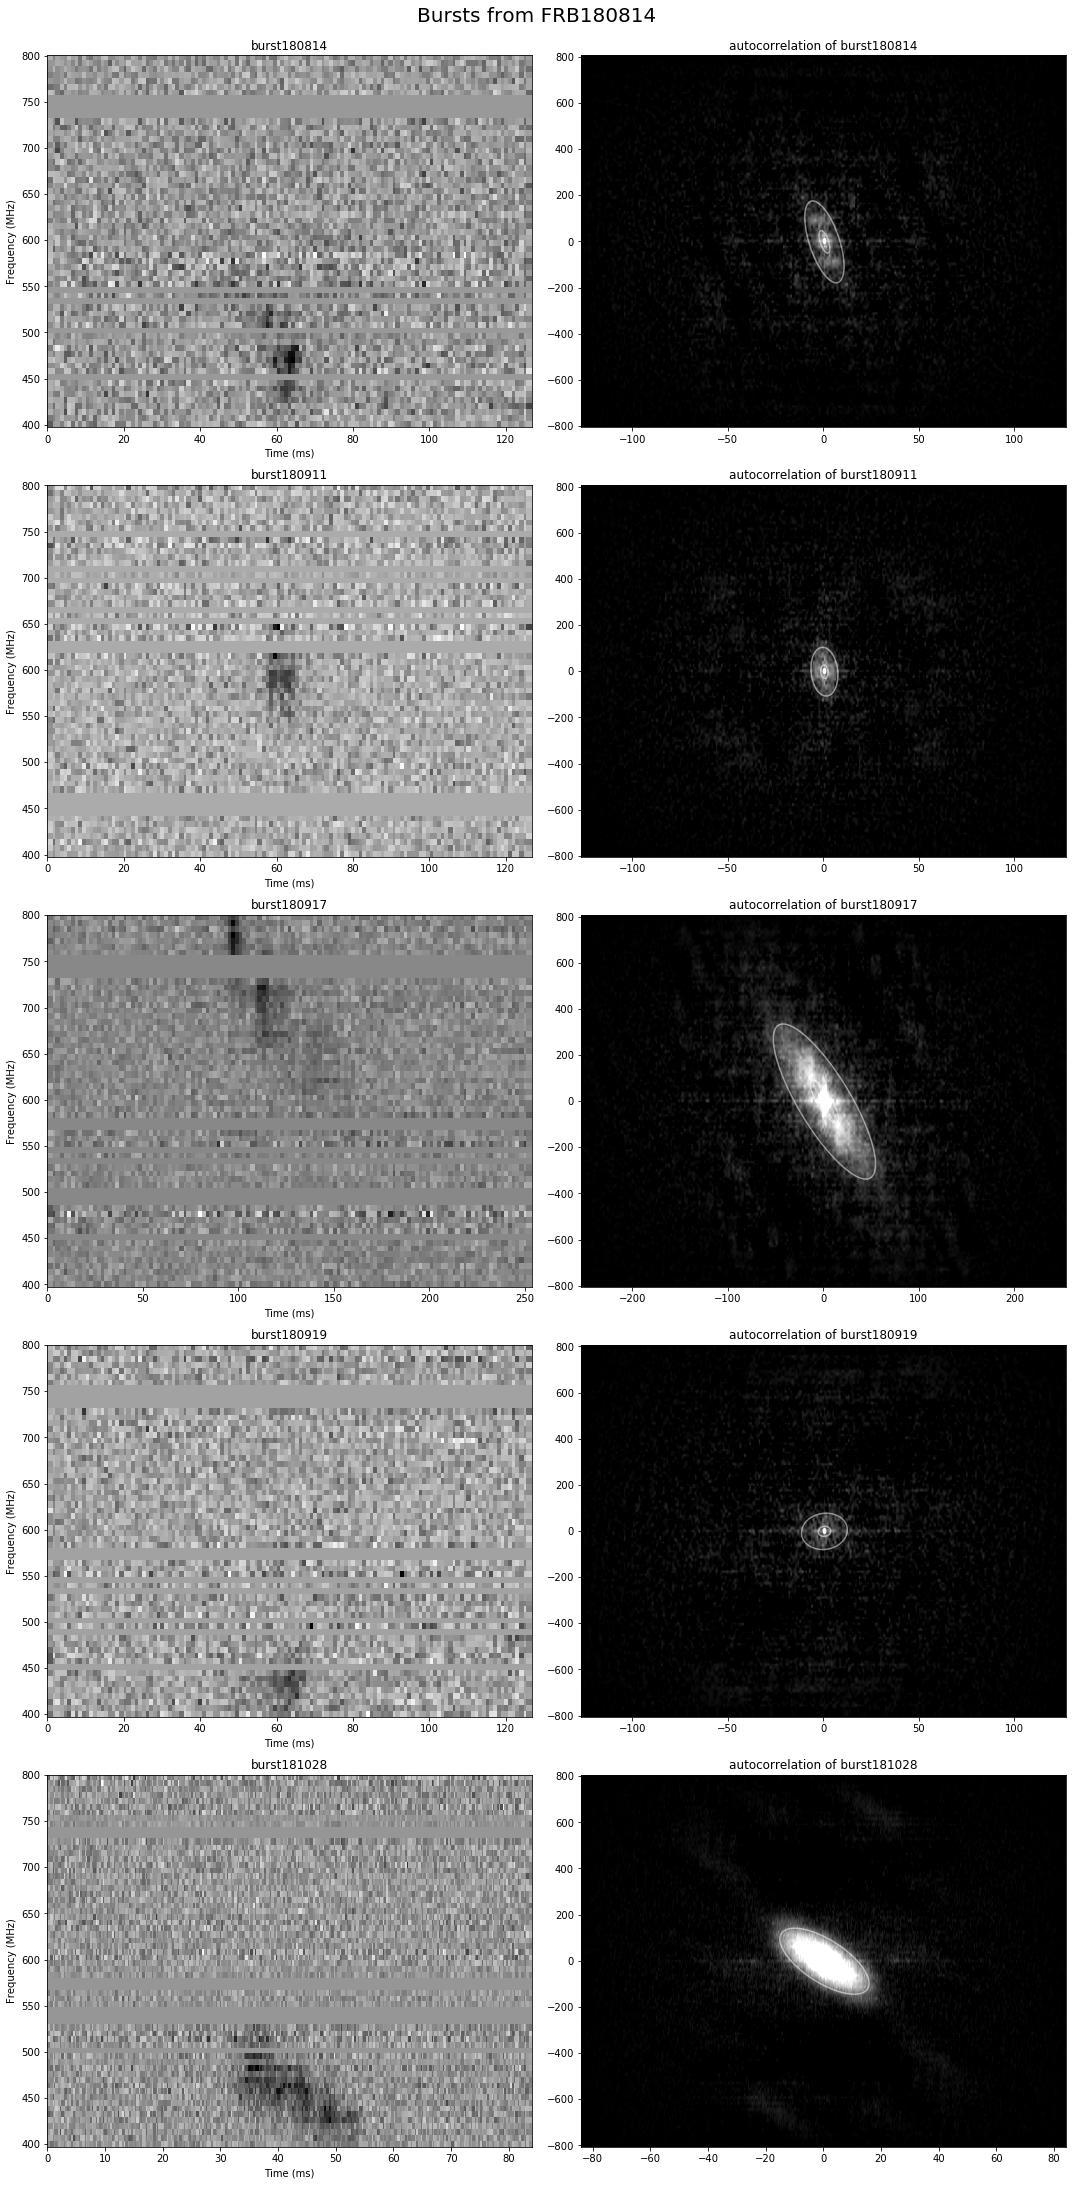

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import os
from tqdm import tqdm
import matplotlib.image as mpimg
import corrfns, fitburst
import itertools

plt.rcParams.update({'figure.max_open_warning': 0})
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]) * rgb[...,3] # last factor is alpha mask

burstfolder = 'data/CHIME_FRB180814.J0422+73'
bursts = [f for f in os.listdir(burstfolder) if '.png' in f]

pixelscales = pd.read_csv('data/CHIME_FRB180814.J0422+73/pixelscales.csv', index_col=0)
timeresolutions = [0.98304, 0.98304, 1.966, 0.98304, 0.328] # ms
parameterfile = 'data/CHIME_FRB180814.J0422+73/chime_180814_img_fit_params.csv'
errorfile     = 'data/CHIME_FRB180814.J0422+73/chime_180814_img_param_errors.csv'

if os.path.exists(parameterfile):
    popts = pd.read_csv(parameterfile, index_col=0)
    perrs = pd.read_csv(errorfile, index_col=0)
else:
    popts, perrs = [], []

drifts       = []
drift_errors = []
red_chisqs   = []
angles       = [] # standardize theta to be in [0, pi] 

cmap = plt.get_cmap('gray')
cmap.set_bad(color = 'k', alpha = 1.) # potentially hides important errors in the data!
plt.figure(figsize=(15,30))
plt.suptitle('Bursts from FRB180814', size=20, y=1.01)
ploti = itertools.count(start=1, step=1)
for filename in tqdm(bursts):
    imfrb = mpimg.imread('{}/{}'.format(burstfolder, filename))
    grayfrb = (1 - rgb2gray(imfrb)) * imfrb[...,3] # 1 is bright, 0 is dim
    burstwindow = grayfrb - grayfrb[:, 0:100].mean(axis=1)[:,None]

    corr = corrfns.auto_corr2D_viafft(burstwindow)
    #### Autocorr noise
    autocorr_sigma = np.std( corr[:, 0:100] )
    # print('autocorr_sigma', autocorr_sigma)
    # auto_sigmas.append(autocorr_sigma)

    #### Fit Gaussian to autocorrelation. Load from parameter file if already found.
    if os.path.exists(parameterfile):
        # print('loading fit...')
        popt, perr = popts.loc[filename.split('.')[0]][:6], perrs.loc[filename.split('.')[0]][:6]
    else:        
        print("finding fit...")
        try:
            popt, pcov = fitburst.fitgaussiannlsq(corr, sigma=autocorr_sigma, p0=[114.78296603, 348.49828412, 650.52374419, 25.22981701, 166.51501372, -9.64579434])
            perr = np.sqrt(np.diag(pcov))
            print('solution nlsq:', popt)
            print('parameter 1sigma:', perr)
            #print('pcov diag:', np.diag(pcov))
        except (RuntimeError, ValueError):
            print('no fit found')
            popt, perr = [-1,-1,-1,-1,-1,-1], [-1,-1,-1,-1,-1,-1]
        popts.append(popt)
        perrs.append(perr)

    x, y = np.meshgrid(range(0, corr.shape[1]), range(0, corr.shape[0]))
    fitmap = fitburst.twoD_Gaussian((y, x), *popt).reshape(corr.shape[0], corr.shape[1])
    
    # calculate reduced chisquared
    residuals = corr - fitmap
    chisq = np.sum((residuals / autocorr_sigma) ** 2)
    red_chisq = chisq / (corr.shape[0]*corr.shape[1] - len(popt)) # this is chisq/(M-N)
    red_chisqs.append(red_chisq)
    # print('reduced chisq:', red_chisq)
    
    # Calculate drifit
    time_res = timeresolutions[bursts.index(filename)] # ms
    freq_res = 6.25 # MHz
    lowest_freq = 400.20751953125 # MHZ
    pixelx_scale = pixelscales.loc[ int(filename.split('burst')[-1].split('.')[0]) ][0] # varies per burst, but usually 348 pixels / 129 points
    pixely_scale = pixelscales.loc[ int(filename.split('burst')[-1].split('.')[0]) ][1] # == 650 pixels / 64 data points

    theta = np.pi/2 - popt[5] if abs(popt[3]) < abs(popt[4]) else -1
    angles.append(theta) if theta > 0 else angles.append(theta + 2*np.pi)
    slope = np.tan(theta) * (pixelx_scale / pixely_scale)
    conversion = freq_res / (time_res)
    drift = conversion * slope # MHz/ms
    theta_err = perr[-1] # do i need to correct this for pixel scale?
    drift_error = conversion * (theta_err * (1/np.cos(theta))**2) * (pixelx_scale / pixely_scale)
    
    drifts.append(drift)
    drift_errors.append(drift_error)
    
    #### Plot
    extents = (0, 
               time_res*burstwindow.shape[1] / pixelx_scale, 
               lowest_freq - freq_res/2., 
               lowest_freq + freq_res*burstwindow.shape[0]/pixely_scale)
    
    corrextents = (-extents[1], extents[1], -(extents[3]-extents[2])*2, (extents[3]-extents[2])*2)
    
    #plt.figure(figsize=(15, 5))
    plt.subplot(5, 2, next(ploti))
    plt.title(filename.split('.')[0])
    plt.imshow(burstwindow, aspect='auto', cmap='gray_r', extent=extents) # white is 0, black is 1
    
    plt.xlabel("Time (ms)")
    plt.ylabel("Frequency (MHz)")

    plt.subplot(5, 2, next(ploti))
    plt.title('autocorrelation of {}'.format(filename.split('.')[0]))
    plt.imshow(corr, aspect='auto', cmap=cmap, extent=corrextents)
    plt.clim(0, np.max(corr)/10)
    if popt[0] != -1:
        plt.contour(fitmap, [popt[0]/4, popt[0]*0.9], colors='w', alpha=0.5, extent=corrextents, origin='upper')

plt.tight_layout()
plt.savefig('bursts180814.png')
    
if not os.path.exists(parameterfile):
    opts = pd.DataFrame(popts, index=[s.split('.')[0] for s in bursts], columns=['amplitude', 'xo', 'yo', 'sigmaxp', 'sigmayp', 'theta'])
    errs = pd.DataFrame(perrs, index=[s.split('.')[0] for s in bursts], columns=['amp_error', 'xo_error', 'yo_error', 'sigmaxp_error', 'sigmayp_error', 'angle_error'])
#     opts.to_csv(parameterfile)
#     errs.to_csv(errorfile)
    popts = opts
    perrs = errs


popts['drift (mhz/ms)']       = drifts
popts['angle']                = angles
perrs['drift error (mhz/ms)'] = drift_errors
perrs['red_chisq']            = red_chisqs


# popts.to_csv(parameterfile)
# perrs.to_csv(errorfile)
popts